# Generating the Milky Way potential using McMillan's standalone GalPot and its python wrapper

We compare the best model from McMillan (2017, henceforth PJM17) with and without central holes
in the HI or H2 gas.

We plot the potential, density, enclosed mass profiles, and rotation curves.

In [14]:
# Some helpful imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate

import mpl_aesth
mpl_aesth.adjust_rcParams('seaborn', use_kpfonts=True, dark_mode=False)
# Linecolors
c = {
   'tot': mpl_aesth.c[3],
   'thin': mpl_aesth.c[1],
   'thick': mpl_aesth.c[2],
   'HI': mpl_aesth.c[0],
   'H2': mpl_aesth.c[5],
   'bul': mpl_aesth.c[6],
   'DM': mpl_aesth.c[7]
}
# Linestyles
ls = {
   'bf': '-',     # Best fit
   'nh': '--',    # No hole
   'nHIh': '-.',  # No HI hole
}

import norm
import physconst as pc
nm = norm.PhysNorm(m=pc.msun, x=pc.kpc, t=pc.Myr, temp=1., curr=1.)

Import GalaxyPotential class

In [15]:
from GalPot import GalaxyPotential

import PJM_functions as PJM

## Calculating the potential

Load the potential file

In [16]:
Phi = GalaxyPotential("pot/PJM17_best.Tpot")
Phi_nh = GalaxyPotential("pot/PJM17_best_nohole.Tpot")
Phi_nHIh = GalaxyPotential("pot/PJM17_best_noHIhole.Tpot")
vconv = Phi.kpc_Myr_to_km_s
phi_plt_norm = vconv ** 2 / 1.e5

Load the density profiles functions

In [17]:
Rho = PJM.PJM_MW("pot/PJM17_best.Tpot")
Rho_nh = PJM.PJM_MW("pot/PJM17_best_nohole.Tpot")
Rho_nHIh = PJM.PJM_MW("pot/PJM17_best_noHIhole.Tpot")

> Note: All the internal workings are in units M<sub>sun</sub>, kpc, Myr (as in the C++ code).
Conversions for velocities can be applied with the helpful GalaxyPotential value kpc_Myr_to_km_s (=977.77)


## The domain

In [18]:
R_min, R_max, nR = 0.1, 30, 1000
z_min, z_max, nz = 0.1, 30, 1000
R = np.linspace(R_min, R_max, nR)
z = np.linspace(z_min, z_max, nz)
RR, zz = np.meshgrid(R, z)
RR, zz = RR.ravel(), zz.ravel()
R0, z0 = np.zeros_like(R), np.zeros_like(z)
R1, R2, R4, R8 = 1. * np.ones_like(R), 2. * np.ones_like(R), 4. * np.ones_like(R), 8. * np.ones_like(R)

Find potential

In [19]:
# Find Potential
phi = Phi.Potential(R, z)
phi_nh = Phi.Potential(R, z)

## Potential as functions of R and z

The following plots show the potential due to all components of the model galaxy

### Potential of R along z = 0, and potential of z along R = 0.

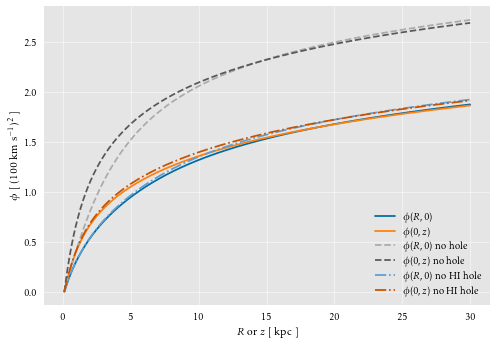

In [20]:
pot_r = Phi.Potential(R, z0) * phi_plt_norm
pot_z = Phi.Potential(R0, z) * phi_plt_norm
pot_r_nh = Phi_nh.Potential(R, z0) * phi_plt_norm
pot_z_nh = Phi_nh.Potential(R0, z) * phi_plt_norm
pot_r_nHIh = Phi_nHIh.Potential(R, z0) * phi_plt_norm
pot_z_nHIh = Phi_nHIh.Potential(R0, z) * phi_plt_norm
pot_r -= pot_r[0]
pot_z -= pot_z[0]
pot_r_nh -= pot_r_nh[0]
pot_z_nh -= pot_z_nh[0]
pot_r_nHIh -= pot_r_nHIh[0]
pot_z_nHIh -= pot_z_nHIh[0]
plt.plot(R, pot_r, label=r'$\phi(R, 0)$')
plt.plot(z, pot_z, label=r'$\phi(0, z)$')
plt.plot(R, pot_r_nh, ls=ls['nh'], label=r'$\phi(R, 0)$ no hole')
plt.plot(z, pot_z_nh, ls=ls['nh'], label=r'$\phi(0, z)$ no hole')
plt.plot(R, pot_r_nHIh, ls=ls['nHIh'], label=r'$\phi(R, 0)$ no HI hole')
plt.plot(z, pot_z_nHIh, ls=ls['nHIh'], label=r'$\phi(0, z)$ no HI hole')
plt.xlabel(r'$R$ or $z$ [ kpc ]')
plt.ylabel(r'$\phi$ [ (100 km s$^{-1}$)$^2$ ]')
plt.legend()
plt.show()

### Two-dimensional potential 

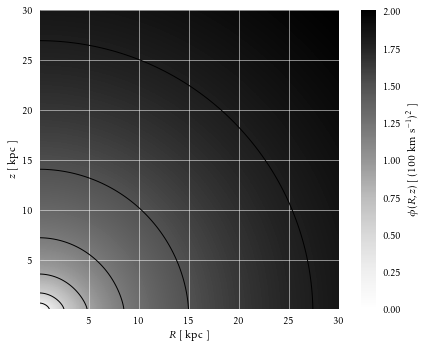

In [21]:
pot_2d = Phi.Potential(RR, zz).reshape(nR, nz) * phi_plt_norm
pot_2d -= pot_2d[0, 0]
# pot_2d_nh = Phi_nh.Potential(RR, zz).reshape(nR, nz) * phi_plt_norm
# pot_2d_nh -= pot_2d_nh[0, 0]
# pot_2d_nHIh = Phi_nHIh.Potential(RR, zz).reshape(nR, nz) * phi_plt_norm
# pot_2d_nHIh -= pot_2d_nHIh[0, 0]

plt.imshow(pot_2d, origin='lower', extent=[R_min, R_max, z_min, z_max])
plt.gca().set_aspect('equal')
plt.colorbar(label=r'$\phi(R, z)$ [ (100 km s$^{-1}$)$^2$ ]')
plt.contour(R, z, pot_2d, colors='k', linewidths=1)
plt.xlabel(r'$R$ [ kpc ]')
plt.ylabel(r'$z$ [ kpc ]')
plt.show()

## Derivatives wrt R & z of potential

In [22]:
dphidr = Phi.Potential_derivatives(RR, zz)

## Density as functions of R for different components

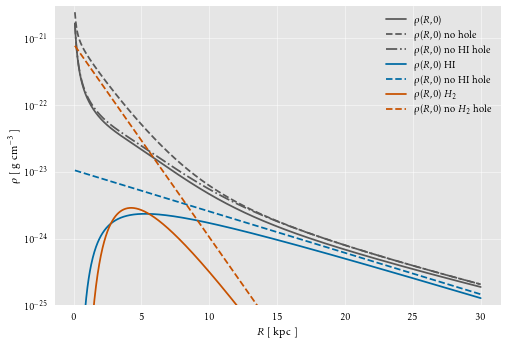

In [23]:
plt.plot(R, Phi.Density(R, z0) * nm.dens, c=c['tot'], ls=ls['bf'], label=r'$\rho(R, 0)$')
plt.plot(R, Phi_nh.Density(R, z0) * nm.dens, c=c['tot'], ls=ls['nh'], label=r'$\rho(R, 0)$ no hole')
plt.plot(R, Phi_nHIh.Density(R, z0) * nm.dens, c=c['tot'], ls=ls['nHIh'], label=r'$\rho(R, 0)$ no HI hole')
plt.plot(R, Rho.HI_disc(R, z0) * nm.dens, c=c['HI'], ls=ls['bf'], label=r'$\rho(R, 0)$ HI')
plt.plot(R, Rho_nh.HI_disc(R, z0) * nm.dens, c=c['HI'], ls=ls['nh'], label=r'$\rho(R, 0)$ no HI hole')
plt.plot(R, Rho.H2_disc(R, z0) * nm.dens, c=c['H2'], ls=ls['bf'], label=r'$\rho(R, 0)$ $H_2$')
plt.plot(R, Rho_nh.H2_disc(R, z0) * nm.dens, c=c['H2'], ls=ls['nh'], label=r'$\rho(R, 0)$ no $H_2$ hole')
plt.semilogy()
plt.ylim(1.e-25, 3.e-21)
plt.xlabel('$R$ [ kpc ]')
plt.ylabel(r'$\rho$ [ g cm$^{-3}$ ]')
plt.legend()
# plt.legend(loc='upper left', bbox_to_anchor=(1.04, 1.0))
plt.show()

## Density as functions of R for different components

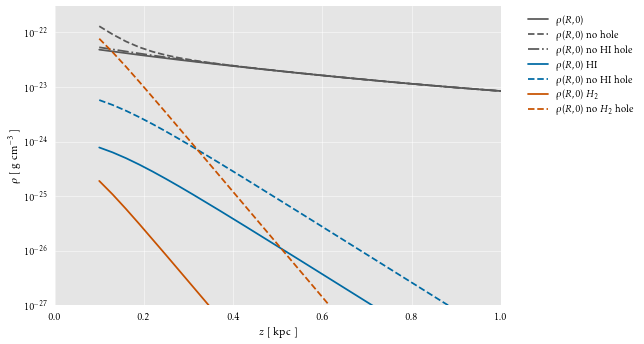

In [24]:
Rs = R2
plt.plot(R, Phi.Density(Rs, z) * nm.dens, c=c['tot'], ls=ls['bf'], label=r'$\rho(R, 0)$')
plt.plot(R, Phi_nh.Density(Rs, z) * nm.dens, c=c['tot'], ls=ls['nh'], label=r'$\rho(R, 0)$ no hole')
plt.plot(R, Phi_nHIh.Density(Rs, z) * nm.dens, c=c['tot'], ls=ls['nHIh'], label=r'$\rho(R, 0)$ no HI hole')
plt.plot(R, Rho.HI_disc(Rs, z) * nm.dens, c=c['HI'], ls=ls['bf'], label=r'$\rho(R, 0)$ HI')
plt.plot(R, Rho_nh.HI_disc(Rs, z) * nm.dens, c=c['HI'], ls=ls['nh'], label=r'$\rho(R, 0)$ no HI hole')
plt.plot(R, Rho.H2_disc(Rs, z) * nm.dens, c=c['H2'], ls=ls['bf'], label=r'$\rho(R, 0)$ $H_2$')
plt.plot(R, Rho_nh.H2_disc(Rs, z) * nm.dens, c=c['H2'], ls=ls['nh'], label=r'$\rho(R, 0)$ no $H_2$ hole')
plt.semilogy()
plt.xlim(0, 1)
plt.ylim(1.e-27, 3.e-22)
plt.xlabel('$z$ [ kpc ]')
plt.ylabel(r'$\rho$ [ g cm$^{-3}$ ]')
plt.legend(loc='upper left', bbox_to_anchor=(1.04, 1.0))
plt.show()

## Enclosed mass as a function of spherical radius

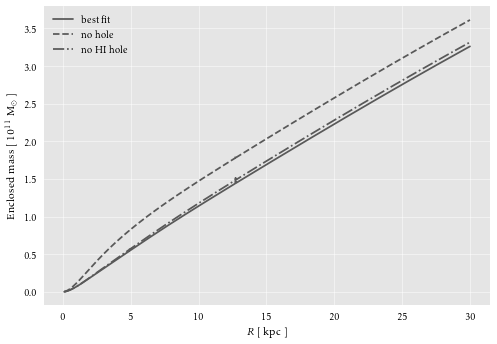

In [25]:
plt.plot(R, Phi.Mass(R) / 1.e11, c=c['tot'], ls=ls['bf'], label='best fit')
plt.plot(R, Phi_nh.Mass(R) / 1.e11, c=c['tot'], ls=ls['nh'], label='no hole')
plt.plot(R, Phi_nHIh.Mass(R) / 1.e11, c=c['tot'], ls=ls['nHIh'], label='no HI hole')
plt.xlabel('$R$ [ kpc ]')
plt.ylabel(r'Enclosed mass [ 10$^{11}$ M$_\odot$ ]')
plt.legend()
plt.show()

## Rotation curve

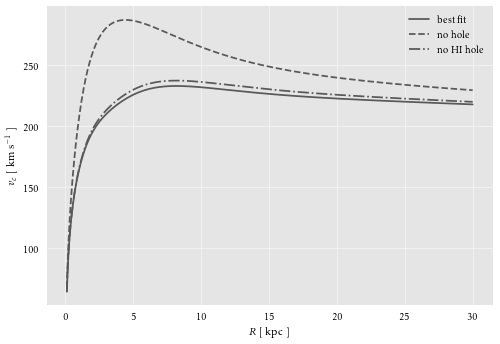

In [26]:
plt.plot(R, Phi.Vcirc(R) * vconv, c=c['tot'], ls=ls['bf'], label='best fit')
plt.plot(R, Phi_nh.Vcirc(R) * vconv, c=c['tot'], ls=ls['nh'], label='no hole')
plt.plot(R, Phi_nHIh.Vcirc(R) * vconv, c=c['tot'], ls=ls['nHIh'], label='no HI hole')
plt.xlabel('$R$ [ kpc ]')
plt.ylabel(r'$v_c$ [ km s$^{-1}$ ]')
plt.legend()
plt.show()
